# Importing Libraries

In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import convolution as con
import random
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten
from keras.models import Model
import tensorflow as tf
from tensordash.tensordash import Tensordash

Using TensorFlow backend.


# Importing Images

In [2]:
x=list()
y=list()
pos=glob.glob("Concrete/Positive/*")
neg=glob.glob("Concrete/Negative/*")
for i in range(20000):
    img=cv2.imread(pos[i],0)
    img=cv2.resize(img,(128,128))
    img=img.reshape(128,128,1)
    x.append(img)
    y.append([1,0])
    img=cv2.imread(neg[i],0)
    img=cv2.resize(img,(128,128))
    img=img.reshape(128,128,1)
    x.append(img)
    y.append([0,1])
    print("Image number : %d"%(i+1),end='\r')
print("\nDone")
x=np.asarray(x)
x=np.float32(x)
x/=255
y=np.asarray(y)
y=np.uint8(y)
np.save('x.npy',x)
np.save('y.npy',y)
del(pos)
del(neg)
del(img)

Image number : 20000
Done


In [2]:
x=np.load('x.npy')
y=np.load('y.npy')

# Processing the image

In [3]:
def converter(img):
    kernel1=np.asarray([[1,0,-1],[1,0,-1],[1,0,-1]])
    kernel2=np.asarray([[1,1,1],[0,0,0],[-1,-1,-1]])
    img=img.reshape((128,128))
    imgedge=np.sqrt(con.convolution(img,kernel1)**2+con.convolution(img,kernel2)**2)
    imgedge=imgedge.reshape((128,128,1))
    return imgedge

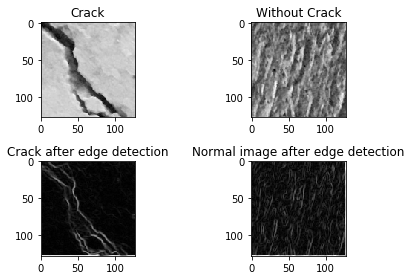

In [4]:
pos=random.randint(0,10000)*2
neg=random.randint(0,10000)*2+1
posedge=converter(x[pos])
negedge=converter(x[neg])

posedge=posedge.reshape((128,128))
negedge=negedge.reshape((128,128))

ax3=plt.subplot(2,2,1)
ax3.imshow(x[pos].reshape((128,128)),cmap='gray')
ax3.set_title('Crack')

ax4=plt.subplot(2,2,2)
ax4.imshow(x[neg].reshape((128,128)),cmap='gray')
ax4.set_title('Without Crack')

ax1=plt.subplot(2,2,3)
ax1.imshow(posedge,cmap='gray')
ax1.set_title('Crack after edge detection')

ax2=plt.subplot(2,2,4)
ax2.imshow(negedge,cmap='gray')
ax2.set_title('Normal image after edge detection')

plt.tight_layout()
plt.show()

In [6]:
x_edge=x.copy()
for i in range(x.shape[0]):
    x_edge[i,:,:,:]=converter(x_edge[i,:,:,:])
    print("Image number : %d"%(i+1),end='\r')
np.save('x_edge.npy',x_edge)
print('\nDone')

Image number : 40000
Done


In [5]:
x_edge=np.load('x_edge.npy')

In [6]:
x_train=x_edge[:-10000]
y_train=y[:-10000]
x_test=x_edge[-10000:]
y_test=y[-10000:]

# Neural Network

In [16]:
inputs=Input(shape=(128,128,1))
x=Conv2D(16, 3, padding='same')(inputs)
x=MaxPool2D()(x)
x=Conv2D(32, 3, padding='same')(x)
x=MaxPool2D()(x)
x=Flatten()(x)
x=Dense(1024, activation='relu')(x)
x=Dense(32, activation='relu')(x)
x=Dense(2, activation='softmax')(x)
model=Model(inputs, x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              3355

In [18]:
tdash=Tensordash(email='sagnik106@gmail.com', password='ZeusTrident3', ModelName='Concrete Crack Detection')

In [19]:
with tf.device("/gpu:0"):
    history=model.fit(x_train, y_train, batch_size=1024, epochs=3, verbose=1, callbacks=[tdash], validation_split=0.1, shuffle=True)

Train on 27000 samples, validate on 3000 samples
Epoch 1/3
27000/27000 [==============================] - 159s 6ms/step - loss: 0.4712 - accuracy: 0.8373 - val_loss: 0.1913 - val_accuracy: 0.9283
Epoch 2/3
27000/27000 [==============================] - 153s 6ms/step - loss: 0.1382 - accuracy: 0.9503 - val_loss: 0.1000 - val_accuracy: 0.9650
Epoch 3/3
27000/27000 [==============================] - 123s 5ms/step - loss: 0.0813 - accuracy: 0.9717 - val_loss: 0.0754 - val_accuracy: 0.9763


# Training Metrics

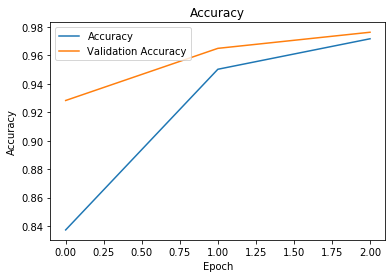

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper left')
plt.savefig("resources/Accuracy.png")
plt.show()

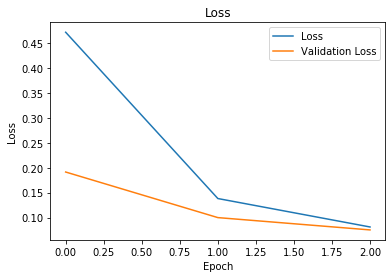

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig("resources/Loss.png")
plt.show()

# Testing

In [22]:
y_pred=model.predict(x_test)
y_pred=np.int8(np.round(y_pred))

In [23]:
e=np.equal(y_pred, y_test)[:,1]

In [24]:
c=0
for i in e:
    if not i:
        c+=1
print("Total images : %d\nAccurate predictions : %d\nInaccurate predictions : %d\nAccuracy : %.3lf"%(e.shape[0],e.shape[0]-c,c,100*((e.shape[0]-c)/e.shape[0])))

Total images : 10000
Accurate predictions : 9779
Inaccurate predictions : 221
Accuracy : 97.790
